# Integration test

In [1]:
import os
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import matplotlib.pyplot as plt

## Input

In [2]:
# 2766
sdata = sc.read_h5ad("J:/2020-10-09-mAD-2766-genes-reads-assignment/output/2021-06-04-starmap-mAD-raw.h5ad")
# 64
rdata = sc.read_h5ad("J:/2021-03-20-mAD-64-genes-reads-assignment/output/2021-04-22-starmap-mAD-64-genes-raw.h5ad")

## Preprocessing

In [3]:
sdata.obs['set'] = '2766-genes'
rdata.obs['set'] = '64-genes'
rdata.obs['cell_type'] = 'NA'

# merge
adata = ad.concat([sdata, rdata], join="inner")

# normalization
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\scanpy\preprocessing\_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


... storing 'sample' as categorical
... storing 'top_level' as categorical
... storing 'cell_type' as categorical
... storing 'set' as categorical


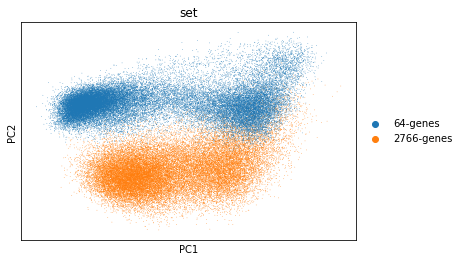

In [4]:
sc.tl.pca(adata)
sc.pl.pca(adata, color='set')

## Harmony

In [5]:
sce.pp.harmony_integrate(adata, 'set')

2021-12-14 16:52:06,659 - harmonypy - INFO - Iteration 1 of 10
2021-12-14 16:53:12,655 - harmonypy - INFO - Iteration 2 of 10
2021-12-14 16:54:14,606 - harmonypy - INFO - Converged after 2 iterations


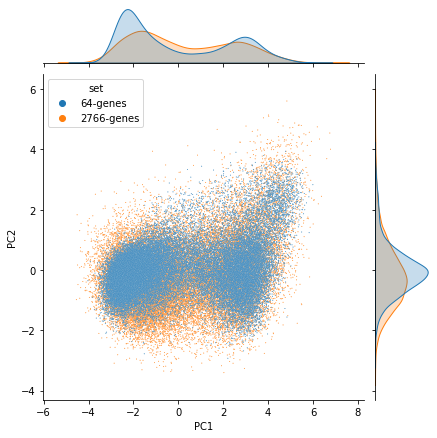

In [6]:
g = sns.jointplot(x=adata.obsm['X_pca_harmony'][:, 0], y=adata.obsm['X_pca_harmony'][:, 1], hue=adata.obs['set'],
                 s=1)
g.set_axis_labels('PC1', 'PC2')
plt.show()

In [7]:
%%time
# Computing the neighborhood graph
n_neighbors = 50
n_pcs = 30
    
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep='X_pca_harmony')

# Run UMAP
sc.tl.umap(adata)

Wall time: 2min 33s


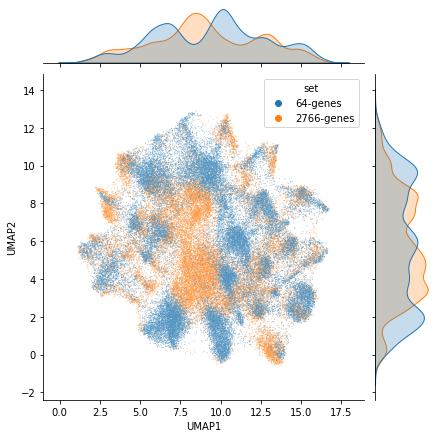

In [8]:
g = sns.jointplot(x=adata.obsm['X_umap'][:, 0], y=adata.obsm['X_umap'][:, 1], hue=adata.obs['set'],
                 s=1, alpha=.5)
g.set_axis_labels('UMAP1', 'UMAP2')
plt.show()

In [9]:
X = adata[adata.obs['set'] == '2766-genes', :].obsm['X_umap']
y = adata.obs.loc[adata.obs['set'] == '2766-genes', 'cell_type'].to_numpy()
Z = adata[adata.obs['set'] == '64-genes', :].obsm['X_umap']

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X, y)
result = neigh.predict(Z)
print(result)

# assign labels
adata.obs.loc[adata.obs['set'] == '64-genes', 'cell_type'] = result
rdata.obs['cell_type'] = result

C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


['L4/5_RSC_A' 'DG' 'Astro_Gfap/Vim' ... 'Peri_A' 'Oligo' 'Oligo']


In [56]:
ndata_2766 = adata[adata.obs['set'] == '2766-genes', :]
ndata_64 = adata[adata.obs['set'] == '64-genes', :]

df_2766 = pd.DataFrame(ndata_2766.X, index=ndata_2766.obs.index, columns=ndata_2766.var.index)
df_2766['top_level'] = ndata_2766.obs['top_level']
df_2766['cell_type'] = ndata_2766.obs['cell_type']
df_2766 = df_2766.groupby('cell_type').mean()
df_2766.index = df_2766.index.astype(str) + '_2766'

df_64 = pd.DataFrame(ndata_64.X, index=ndata_64.obs.index, columns=ndata_64.var.index)
df_64['top_level'] = ndata_64.obs['top_level']
df_64['cell_type'] = ndata_64.obs['cell_type']
df_64 = df_64.groupby('cell_type').mean()
df_64.index = df_64.index.astype(str) + '_64'
df_64

df_complete = pd.concat([df_2766, df_64])
df_complete

C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,ALDOC,AP2B1,APOE,AQP4,BRINP1,BSG,C1QA,C1QL3,C4B,CACNG4,...,SRRM2,SST,TGFBR1,TMSB4X,TREM2,TSHZ2,TSPAN7,VIM,VIP,VTN
cell_type,,,,,,,,,,,,,,,,,,,,,
Astro_2766,1.234763,-0.646737,-0.007723,0.297231,-0.561559,-0.352572,-0.221970,-0.457672,-0.281958,-0.014117,...,-0.003106,-0.063198,-0.223990,-0.853629,-0.256158,-0.096417,0.850247,-0.080168,-0.020175,-0.041592
Astro_Cst3_2766,1.243048,-0.662098,0.545288,1.393817,-0.708891,-0.354798,-0.244261,-0.570290,-0.129242,-0.029136,...,-0.152690,-0.117090,-0.204337,-1.276249,-0.247748,-0.255071,1.078018,0.247634,-0.098556,-0.109277
Astro_Gfap/Vim_2766,1.027613,-0.677802,0.654250,2.660686,-0.699740,-0.404517,-0.136943,-0.542381,0.107911,0.062244,...,-0.289608,-0.151333,-0.241981,-1.000491,-0.238603,-0.202959,0.473943,2.178975,-0.029463,-0.025412
CA1_2766,-0.453341,-0.500941,-0.681077,-0.081898,0.399726,-0.237530,-0.266457,-0.149767,-0.271906,-0.008092,...,0.369046,-0.158891,-0.265679,1.425071,-0.234182,-0.266885,-0.298993,-0.128645,0.172775,0.040618
CA2_2766,-0.301434,-0.604699,-0.611567,-0.002162,0.240536,-0.147868,-0.176274,-0.484205,-0.276249,-0.044313,...,-0.055176,-0.162365,-0.216661,1.549410,-0.151943,-0.277504,0.259263,-0.182449,0.330944,0.006959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pvalb_Nog_64,0.503160,0.660214,0.072338,-0.209716,-0.252455,0.880812,-0.376452,-0.479584,-0.187769,0.098828,...,0.370379,-0.050882,-0.290411,-0.277929,-0.327725,-0.048929,0.261297,-0.119550,-0.136581,-0.290814
SMC_64,0.272976,0.025161,1.600693,0.104694,-0.785020,0.697324,0.036588,-0.476323,0.430926,-0.175957,...,-0.071235,-0.184044,0.157881,-0.012535,0.044944,0.028539,-0.404255,3.217198,-0.073627,1.482905
Sst_64,0.005451,0.888086,0.043515,-0.137413,-0.047365,0.299908,-0.211875,-0.288162,-0.105699,0.176997,...,-0.203629,5.718100,0.009682,-0.576090,-0.105345,0.115002,-0.131256,-0.105763,-0.075592,0.025138


In [57]:
df_complete.T.corr()

cell_type,Astro_2766,Astro_Cst3_2766,Astro_Gfap/Vim_2766,CA1_2766,CA2_2766,CA3_2766,Cnr1_2766,DG_2766,Endo_2766,Endo_Cldn5+_2766,...,Oligo_Cldn11_64,Oligo_Klk6_64,Peri_A_64,Peri_B_64,Pvalb_64,Pvalb_Nog_64,SMC_64,Sst_64,VLMC_A_64,Vip_64
cell_type,,,,,,,,,,,,,,,,,,,,,
Astro_2766,1.000000,0.922839,0.625649,-0.098606,-0.009512,0.080875,0.064702,0.025301,0.194859,0.189353,...,-0.114453,-0.099474,0.149357,0.129981,-0.127954,0.014805,0.171867,-0.061740,0.204283,-0.006472
Astro_Cst3_2766,0.922839,1.000000,0.816094,-0.247945,-0.178718,-0.107635,-0.007816,-0.133808,0.183577,0.186427,...,0.009406,-0.027897,0.221690,0.197056,-0.172147,-0.032285,0.224618,-0.072173,0.334080,-0.024654
Astro_Gfap/Vim_2766,0.625649,0.816094,1.000000,-0.242728,-0.199191,-0.175259,-0.042953,-0.180123,0.302041,0.293627,...,0.114065,0.042901,0.279398,0.259694,-0.210231,-0.123725,0.329238,-0.107551,0.429334,-0.049161
CA1_2766,-0.098606,-0.247945,-0.242728,1.000000,0.822775,0.699528,0.197965,0.687046,0.035715,0.015448,...,-0.415100,-0.251660,-0.277267,-0.270836,-0.057260,-0.050813,-0.141900,-0.138327,-0.368124,0.015160
CA2_2766,-0.009512,-0.178718,-0.199191,0.822775,1.000000,0.755330,0.229039,0.503601,0.078003,0.042832,...,-0.384051,-0.227547,-0.264608,-0.260746,-0.034983,-0.039582,-0.168775,-0.129310,-0.344651,0.035394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pvalb_Nog_64,0.014805,-0.032285,-0.123725,-0.050813,-0.039582,-0.104601,0.051903,-0.127537,-0.064713,-0.070825,...,-0.126166,-0.097178,-0.148748,-0.139107,0.920568,1.000000,-0.125776,0.384427,-0.107734,0.211502
SMC_64,0.171867,0.224618,0.329238,-0.141900,-0.168775,-0.205702,-0.099334,-0.161354,0.386404,0.386370,...,0.101705,0.038442,0.478165,0.493292,-0.145029,-0.125776,1.000000,-0.084546,0.527440,-0.076885
Sst_64,-0.061740,-0.072173,-0.107551,-0.138327,-0.129310,-0.138902,0.089482,-0.179464,-0.065897,-0.068843,...,-0.007386,-0.047299,-0.056976,-0.054100,0.324607,0.384427,-0.084546,1.000000,-0.058937,0.155555


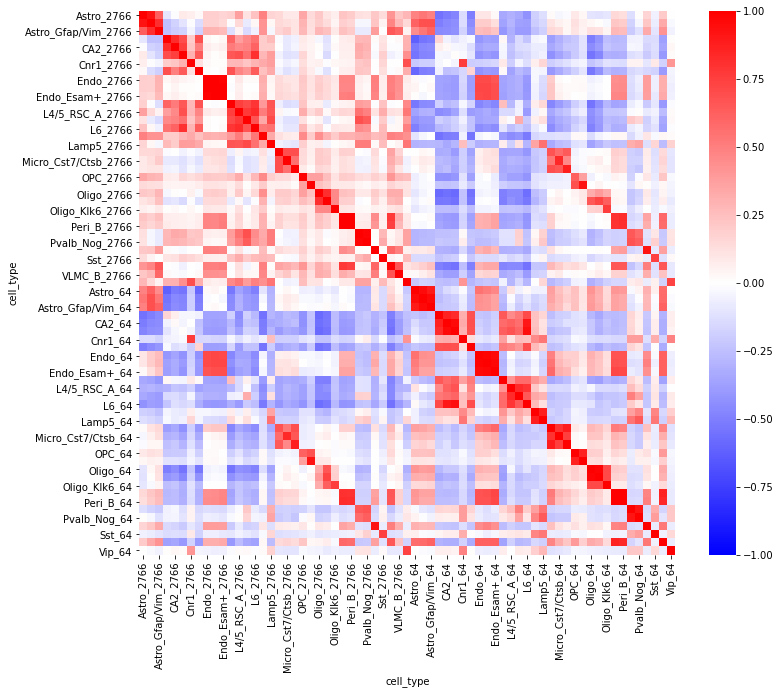

In [58]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_complete.T.corr(), cmap='bwr', vmin=-1, vmax=1)
plt.show()

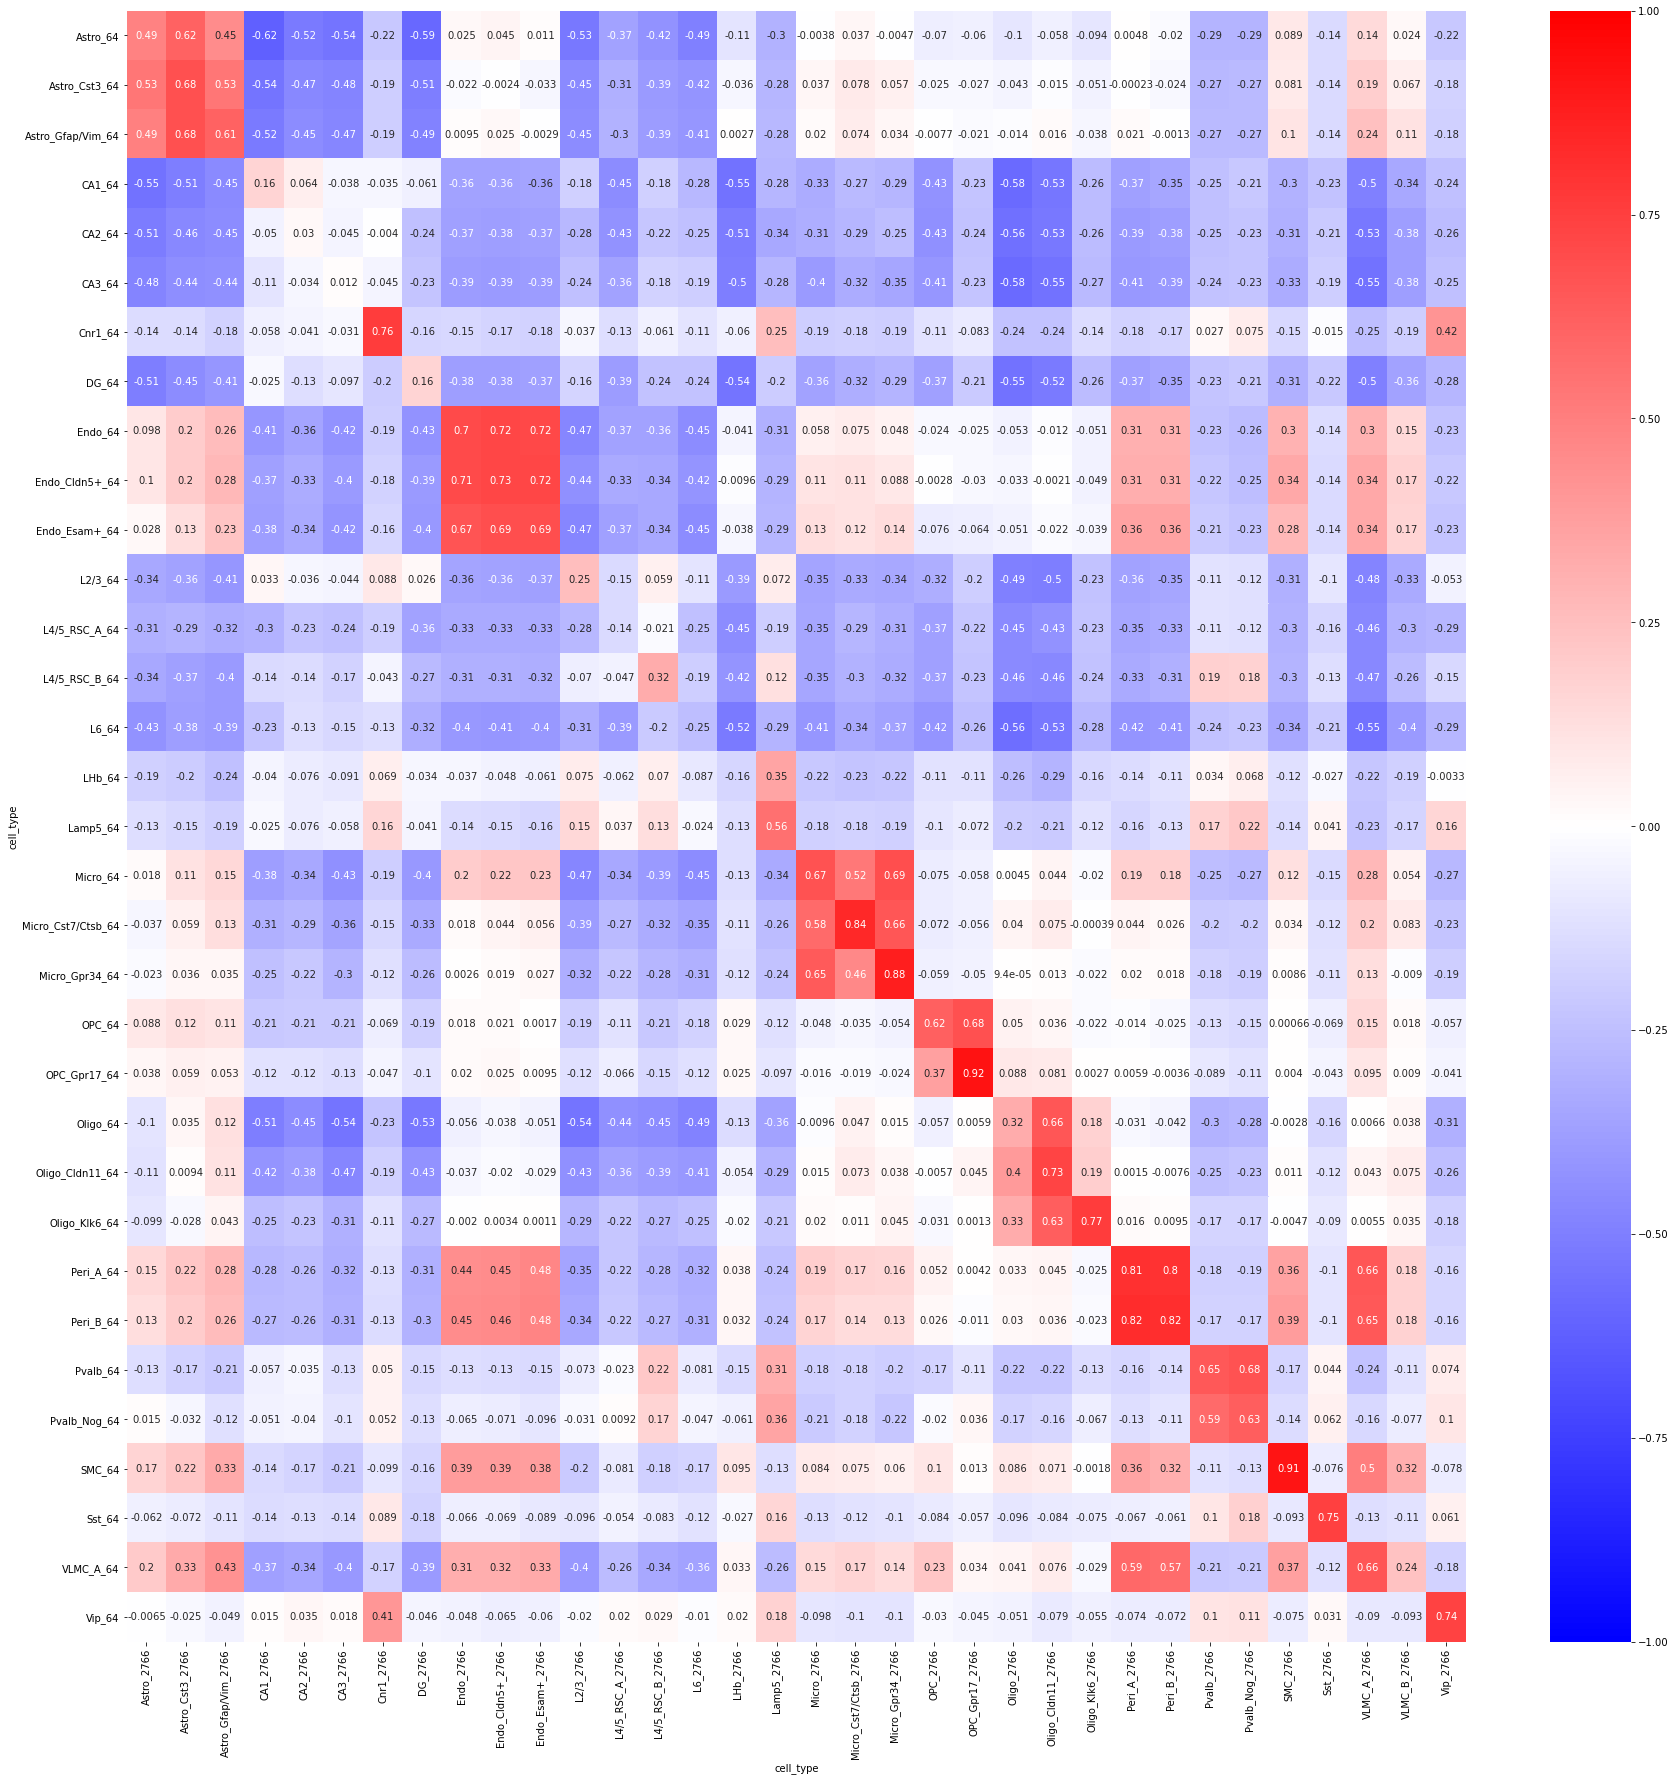

In [62]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(df_complete.T.corr().iloc[34:, :34], cmap='bwr', vmin=-1, vmax=1, annot=True)
plt.show()

In [ ]:
confusion_matrix = pd.crosstab(adata.obs.loc[:, 'phase_ref'], adata.obs.loc[:, 'phase_new'], rownames=['Use reference list'], colnames=['Use our list'])
sns.heatmap(confusion_matrix, annot=True, fmt='')
plt.show()